In [4]:
import os
import cv2
import numpy as np
import seaborn as sns

In [6]:
# Data paths
dataset_path = '/kaggle/input'  # Replace with your dataset path

# Image dimensions
img_width, img_height = 150, 150  # Adjust as needed

# Preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return cv2.resize(equalized, (img_width, img_height))

print('Pre-Processing Done')

# Load and preprocess images
X = []
y = []

count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    for image_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image_name)
        try:
            img_data = preprocess_image(img_path)
            X.append(img_data)
            y.append(folder)  # Use folder name as label
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")  # Handle errors gracefully

# Convert to numpy arrays
X = np.array(X).astype('float32') / 255.0
y = np.array(y)

# Reshape X to have rank 4
X = np.expand_dims(X, axis=-1)

# One-hot encode labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))




Pre-Processing Done
/kaggle/input ['cushion', 'oval', 'princess', 'heart', 'round', 'pear', 'emerald']
/kaggle/input/cushion []
/kaggle/input/oval []
/kaggle/input/princess []
/kaggle/input/heart []
/kaggle/input/round []
/kaggle/input/pear []
/kaggle/input/emerald []


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


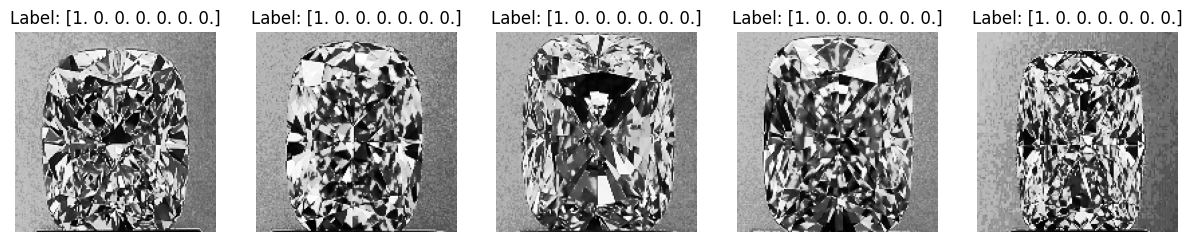

In [8]:
import matplotlib.pyplot as plt

# Display some pre-processed images
num_examples = 5  # Number of examples to display
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

for i in range(num_examples):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].set_title(f'Label: {y[i]}')
    axes[i].axis('off')

plt.show()


In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# Convert one-hot encoded labels to integers
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(np.argmax(y, axis=1))

# Flatten the images into 1D arrays
X_flatten = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_flatten, y_int, test_size=0.2, random_state=42)

# SVM model
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0, random_state=42, probability= True ))
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy}")


SVM Accuracy: 0.988


In [22]:
# ROC Curve for SVM
y_prob_svm = svm_model.predict_proba(X_test)
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

for i in range(len(label_encoder.classes_)):
    fpr_svm[i], tpr_svm[i], _ = roc_curve(label_binarize(y_test, classes=label_encoder.classes_)[:, i], y_prob_svm[:, i])
    roc_auc_svm[i] = auc(fpr_svm[i], tpr_svm[i])

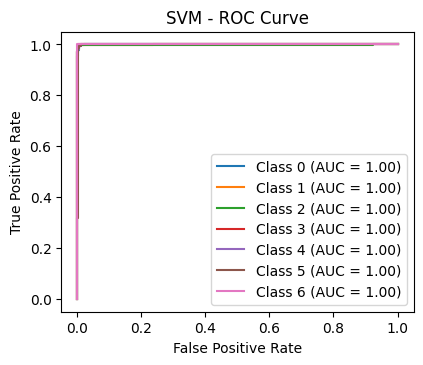

In [23]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# SVM
plt.subplot(2, 2, 1)
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_svm[i], tpr_svm[i], label=f'Class {i} (AUC = {roc_auc_svm[i]:.2f})')

plt.title('SVM - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       260
           1       1.00      0.99      0.99       258
           2       0.99      0.98      0.99       252
           3       0.99      1.00      0.99       249
           4       0.99      0.97      0.98       253
           5       0.98      0.99      0.98       242
           6       1.00      1.00      1.00       236

    accuracy                           0.99      1750
   macro avg       0.99      0.99      0.99      1750
weighted avg       0.99      0.99      0.99      1750


Confusion Matrix:


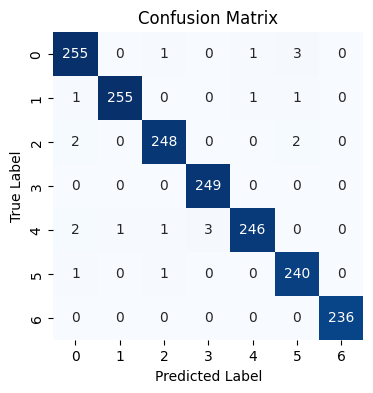

In [55]:
#Classification report, and confusion matrix for SVM
import seaborn as sns

print("Classification Report:")
print(classification_report(y_test, svm_predictions))

# Print confusion matrix with labels
conf_matrix = confusion_matrix(y_test, svm_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\nConfusion Matrix:")

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

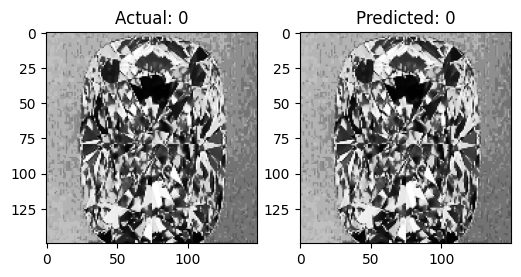

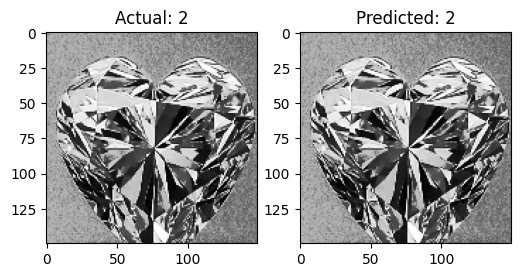

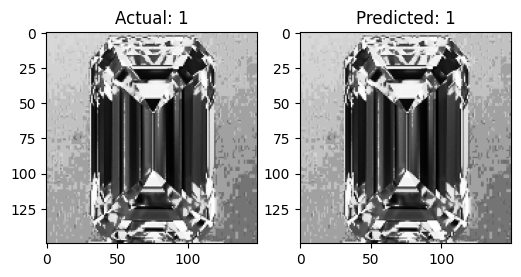

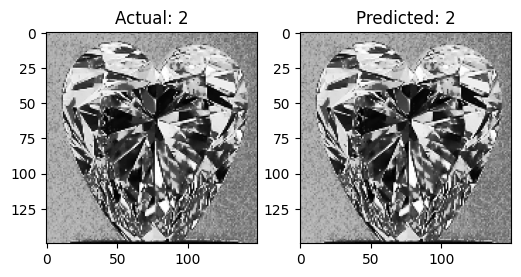

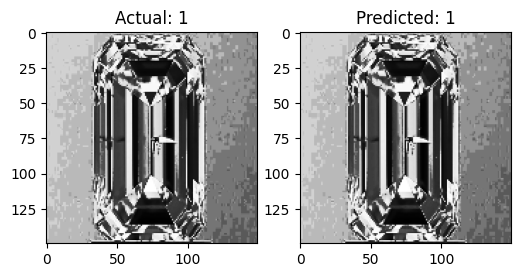

In [79]:
# Convert flattened images back to original shape
X_test_reshaped = X_test.reshape(X_test.shape[0], 150,150)

# Choose a few random samples to visualize
num_samples_to_visualize = 5
random_indices = np.random.choice(X_test.shape[0], num_samples_to_visualize, replace=False)

# Visualize actual and predicted values along with images
for index in random_indices:
    actual_label = label_encoder.inverse_transform([y_test[index]])[0]
    predicted_label = label_encoder.inverse_transform([svm_predictions[index]])[0]

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test_reshaped[index], cmap='gray')
    plt.title(f"Actual: {actual_label}")

    plt.subplot(1, 2, 2)
    plt.imshow(X_test_reshaped[index], cmap='gray')
    plt.title(f"Predicted: {predicted_label}")

    plt.show()

In [31]:
# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print(f"Decision Tree Accuracy: {dt_accuracy}")



Decision Tree Accuracy: 0.8308571428571428


In [56]:
# ROC Curve for Decision Tree
y_prob_dt = dt_model.predict_proba(X_test)
fpr_dt = dict()
tpr_dt = dict()
roc_auc_dt = dict()

for i in range(len(label_encoder.classes_)):
    fpr_dt[i], tpr_dt[i], _ = roc_curve(label_binarize(y_test, classes=label_encoder.classes_)[:, i], y_prob_dt[:, i])
    roc_auc_dt[i] = auc(fpr_dt[i], tpr_dt[i])

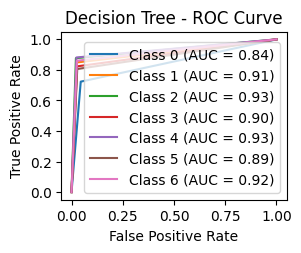

In [37]:
# Decision Tree
plt.subplot(2, 2, 2)
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_dt[i], tpr_dt[i], label=f'Class {i} (AUC = {roc_auc_dt[i]:.2f})')

plt.title('Decision Tree - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73       260
           1       0.85      0.85      0.85       258
           2       0.87      0.88      0.88       252
           3       0.83      0.82      0.83       249
           4       0.86      0.88      0.87       253
           5       0.82      0.81      0.81       242
           6       0.84      0.86      0.85       236

    accuracy                           0.83      1750
   macro avg       0.83      0.83      0.83      1750
weighted avg       0.83      0.83      0.83      1750


Confusion Matrix:


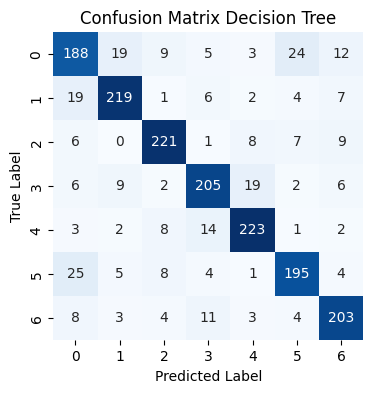

In [59]:
#Classification report, and confusion matrix for SVM
import seaborn as sns

print("Classification Report:")
print(classification_report(y_test, dt_predictions))

# Print confusion matrix with labels
conf_matrix = confusion_matrix(y_test, dt_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\nConfusion Matrix:")

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

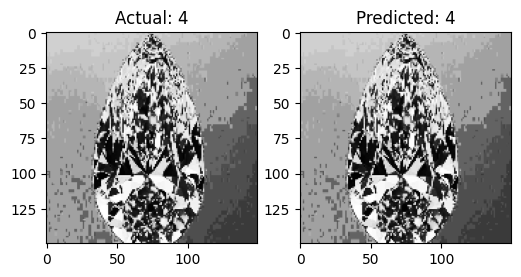

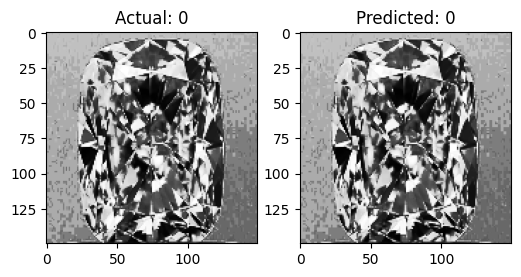

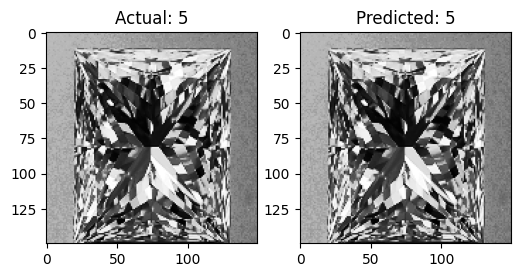

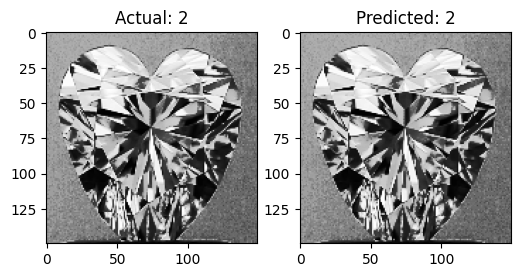

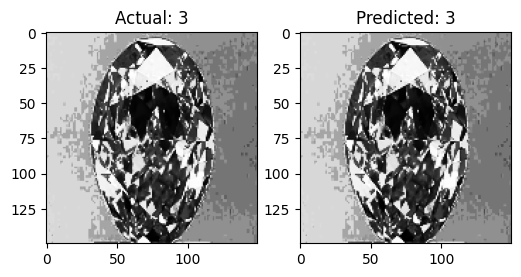

In [80]:
# Convert flattened images back to original shape
X_test_reshaped = X_test.reshape(X_test.shape[0], 150,150)

# Choose a few random samples to visualize
num_samples_to_visualize = 5
random_indices = np.random.choice(X_test.shape[0], num_samples_to_visualize, replace=False)

# Visualize actual and predicted values along with images
for index in random_indices:
    actual_label = label_encoder.inverse_transform([y_test[index]])[0]
    predicted_label = label_encoder.inverse_transform([dt_predictions[index]])[0]

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test_reshaped[index], cmap='gray')
    plt.title(f"Actual: {actual_label}")

    plt.subplot(1, 2, 2)
    plt.imshow(X_test_reshaped[index], cmap='gray')
    plt.title(f"Predicted: {predicted_label}")

    plt.show()

In [32]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.976


In [67]:
# ROC Curve for Random Forest
y_prob_rf = rf_model.predict_proba(X_test)
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

for i in range(len(label_encoder.classes_)):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(label_binarize(y_test, classes=label_encoder.classes_)[:, i], y_prob_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

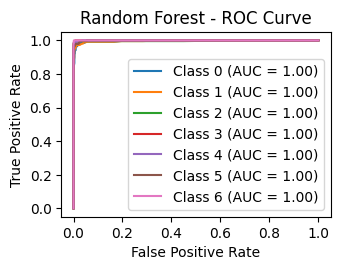

In [68]:
# Random Forest
plt.subplot(2, 2, 3)
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'Class {i} (AUC = {roc_auc_rf[i]:.2f})')

plt.title('Random Forest - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       260
           1       0.96      0.95      0.96       258
           2       1.00      0.97      0.99       252
           3       0.96      1.00      0.98       249
           4       0.98      0.98      0.98       253
           5       0.99      0.98      0.99       242
           6       0.98      1.00      0.99       236

    accuracy                           0.98      1750
   macro avg       0.98      0.98      0.98      1750
weighted avg       0.98      0.98      0.98      1750


Confusion Matrix:


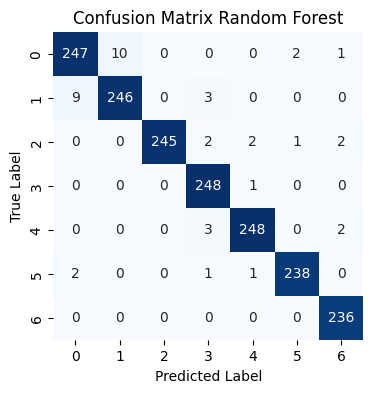

In [70]:
print("Classification Report:")
print(classification_report(y_test, rf_predictions))

# Print confusion matrix with labels
conf_matrix = confusion_matrix(y_test, rf_predictions)
conf_matrix_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\nConfusion Matrix:")

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

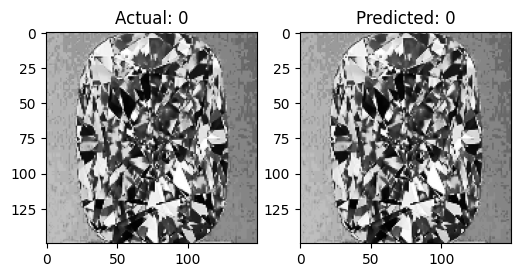

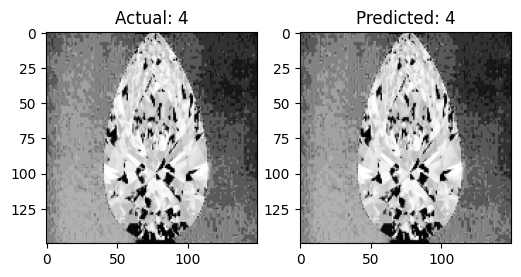

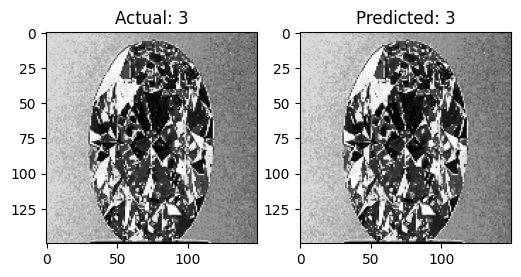

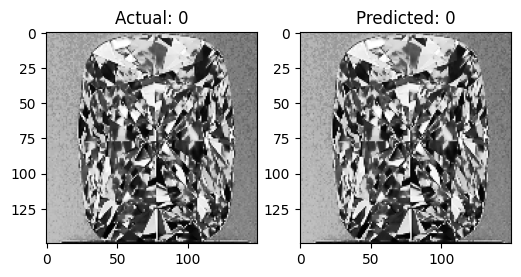

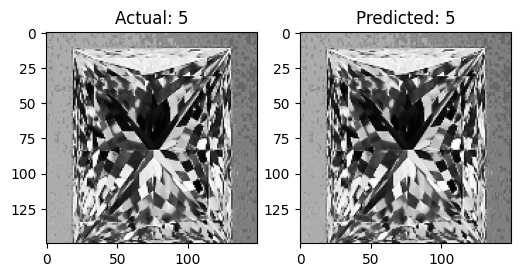

In [82]:
# Convert flattened images back to original shape
X_test_reshaped = X_test.reshape(X_test.shape[0], 150,150)

# Choose a few random samples to visualize
num_samples_to_visualize = 5
random_indices = np.random.choice(X_test.shape[0], num_samples_to_visualize, replace=False)

# Visualize actual and predicted values along with images
for index in random_indices:
    actual_label = label_encoder.inverse_transform([y_test[index]])[0]
    predicted_label = label_encoder.inverse_transform([rf_predictions[index]])[0]

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_test_reshaped[index], cmap='gray')
    plt.title(f"Actual: {actual_label}")

    plt.subplot(1, 2, 2)
    plt.imshow(X_test_reshaped[index], cmap='gray')
    plt.title(f"Predicted: {predicted_label}")

    plt.show()